### Imports

In [1]:
import torch

In [2]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 30.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 50.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 38.5 MB/s eta 0:00:00


In [3]:
%%capture
!pip install torch_geometric
!pip install ogb

In [4]:
import numpy as np
import random
import os

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data.storage import GlobalStorage
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
from torch_geometric.nn import Sequential, global_mean_pool, global_add_pool
from torch_geometric.nn.conv import GCNConv, GATv2Conv, ChebConv
from torch_geometric.loader import DataLoader
from torch_geometric.utils import softmax, get_laplacian, to_scipy_sparse_matrix, to_dense_adj
from torch_scatter import scatter_softmax, scatter_add

from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from sklearn.metrics import accuracy_score, roc_auc_score

In [5]:
# !pip freeze > requirements.txt

### Set seeds for reproducibility

In [6]:
torch.serialization.add_safe_globals([GlobalStorage, DataEdgeAttr, DataTensorAttr])

In [7]:
SEED = 42
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

### Load ogbg-molhiv dataset

In [74]:
dataset = PygGraphPropPredDataset(name = "ogbg-molhiv", root = 'dataset/')
split_idx = dataset.get_idx_split()

### Baseline GCN

In [83]:
SEED = 42
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [84]:
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.0):
        super().__init__()
        self.gat1 = GCNConv(in_dim, hidden_dim)
        self.gat2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim, out_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch):
        x = x.float()
        x = F.elu(self.gat1(x, edge_index))
        x = self.dropout1(x)
        x = F.elu(self.gat2(x, edge_index))
        x = self.dropout2(x)
        x = global_mean_pool(x, batch)
        out = self.lin(x)
        return out

In [85]:
BATCH_SIZE = 64
NUM_EPOCHS = 65
LEARNING_RATE = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [86]:
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=BATCH_SIZE, shuffle=False)

In [87]:
gcn_model = GCN(
    in_dim=dataset.num_node_features,
    hidden_dim=128,
    out_dim=1,
).to(DEVICE)

In [88]:
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, min_lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()
evaluator = Evaluator(name="ogbg-molhiv")

In [89]:
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(DEVICE)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch).view(-1)
        loss = criterion(out, data.y.view(-1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []
    for data in loader:
        data = data.to(DEVICE)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.view(-1), data.y.view(-1).float())
        total_loss += loss.item() * data.num_graphs
        y_true.append(data.y)
        y_pred.append(out)

    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    avg_loss = total_loss / len(loader.dataset)
    rocauc = evaluator.eval({'y_true': y_true, 'y_pred': y_pred})['rocauc']
    return avg_loss, rocauc

In [90]:
gcn_train_losses = []
gcn_val_losses = []
gcn_val_rocaucs = []
for epoch in range(1, NUM_EPOCHS + 1):
    loss = train(gcn_model, train_loader, optimizer)
    val_loss, val_rocauc = evaluate(gcn_model, valid_loader)
    scheduler.step(val_rocauc)
    print(f"Epoch {epoch:03d} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f} | Val ROC-AUC: {val_rocauc:.4f}")
    gcn_train_losses.append(loss)
    gcn_val_losses.append(val_loss)
    gcn_val_rocaucs.append(val_rocauc)

Epoch 001 | Train Loss: 0.1634 | Val Loss: 0.1014 | Val ROC-AUC: 0.6347
Epoch 002 | Train Loss: 0.1598 | Val Loss: 0.0972 | Val ROC-AUC: 0.6310
Epoch 003 | Train Loss: 0.1595 | Val Loss: 0.1089 | Val ROC-AUC: 0.6224
Epoch 004 | Train Loss: 0.1597 | Val Loss: 0.0958 | Val ROC-AUC: 0.6249
Epoch 005 | Train Loss: 0.1592 | Val Loss: 0.1001 | Val ROC-AUC: 0.6258
Epoch 006 | Train Loss: 0.1596 | Val Loss: 0.1053 | Val ROC-AUC: 0.6215
Epoch 007 | Train Loss: 0.1587 | Val Loss: 0.1036 | Val ROC-AUC: 0.6222
Epoch 008 | Train Loss: 0.1584 | Val Loss: 0.0967 | Val ROC-AUC: 0.6240
Epoch 009 | Train Loss: 0.1582 | Val Loss: 0.1046 | Val ROC-AUC: 0.6276
Epoch 010 | Train Loss: 0.1581 | Val Loss: 0.1015 | Val ROC-AUC: 0.6231
Epoch 011 | Train Loss: 0.1581 | Val Loss: 0.1025 | Val ROC-AUC: 0.6306
Epoch 012 | Train Loss: 0.1581 | Val Loss: 0.0975 | Val ROC-AUC: 0.6275
Epoch 013 | Train Loss: 0.1577 | Val Loss: 0.1006 | Val ROC-AUC: 0.6261
Epoch 014 | Train Loss: 0.1572 | Val Loss: 0.1055 | Val ROC-AUC:

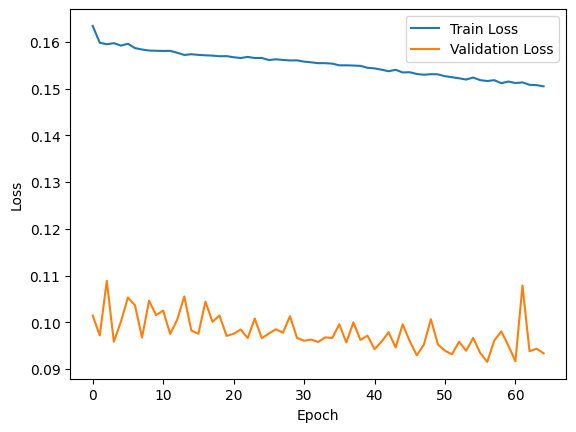

In [91]:
plt.plot(gcn_train_losses, label='Train Loss')
plt.plot(gcn_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

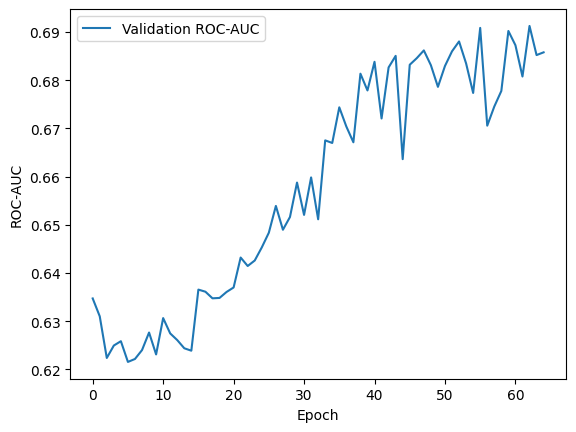

In [92]:
plt.plot(gcn_val_rocaucs, label='Validation ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.legend()

### Baseline GAT

In [9]:
SEED = 42
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [10]:
class GAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=8, dropout=0.0):
        super().__init__()
        self.gat1 = GATv2Conv(in_dim, hidden_dim, heads=heads, concat=True, dropout=dropout)
        self.gat2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=dropout)
        self.lin = nn.Linear(hidden_dim, out_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch):
        x = x.float()
        x = F.elu(self.gat1(x, edge_index))
        x = self.dropout1(x)
        x = F.elu(self.gat2(x, edge_index))
        x = self.dropout2(x)
        x = global_mean_pool(x, batch)
        out = self.lin(x)
        return out

In [11]:
BATCH_SIZE = 64
NUM_EPOCHS = 65
LEARNING_RATE = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=BATCH_SIZE, shuffle=False)

In [13]:
gat_model = GAT(
    in_dim=dataset.num_node_features,
    hidden_dim=128,
    out_dim=1,
    heads=4
).to(DEVICE)

In [14]:
optimizer = torch.optim.Adam(gat_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, min_lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()
evaluator = Evaluator(name="ogbg-molhiv")

In [15]:
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(DEVICE)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch).view(-1)
        loss = criterion(out, data.y.view(-1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []
    for data in loader:
        data = data.to(DEVICE)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.view(-1), data.y.view(-1).float())
        total_loss += loss.item() * data.num_graphs
        y_true.append(data.y)
        y_pred.append(out)

    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    avg_loss = total_loss / len(loader.dataset)
    rocauc = evaluator.eval({'y_true': y_true, 'y_pred': y_pred})['rocauc']
    return avg_loss, rocauc

In [16]:
gat_train_losses = []
gat_val_losses = []
gat_val_rocaucs = []
for epoch in range(1, NUM_EPOCHS + 1):
    loss = train(gat_model, train_loader, optimizer)
    val_loss, val_rocauc = evaluate(gat_model, valid_loader)
    scheduler.step(val_rocauc)
    print(f"Epoch {epoch:03d} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f} | Val ROC-AUC: {val_rocauc:.4f}")
    gat_train_losses.append(loss)
    gat_val_losses.append(val_loss)
    gat_val_rocaucs.append(val_rocauc)

Epoch 001 | Train Loss: 0.1625 | Val Loss: 0.0997 | Val ROC-AUC: 0.6253
Epoch 002 | Train Loss: 0.1595 | Val Loss: 0.0950 | Val ROC-AUC: 0.6473
Epoch 003 | Train Loss: 0.1557 | Val Loss: 0.0947 | Val ROC-AUC: 0.6712
Epoch 004 | Train Loss: 0.1530 | Val Loss: 0.0950 | Val ROC-AUC: 0.6924
Epoch 005 | Train Loss: 0.1521 | Val Loss: 0.0988 | Val ROC-AUC: 0.6945
Epoch 006 | Train Loss: 0.1519 | Val Loss: 0.1002 | Val ROC-AUC: 0.6771
Epoch 007 | Train Loss: 0.1510 | Val Loss: 0.0907 | Val ROC-AUC: 0.6930
Epoch 008 | Train Loss: 0.1508 | Val Loss: 0.0910 | Val ROC-AUC: 0.6913
Epoch 009 | Train Loss: 0.1505 | Val Loss: 0.0927 | Val ROC-AUC: 0.6897
Epoch 010 | Train Loss: 0.1503 | Val Loss: 0.0914 | Val ROC-AUC: 0.6778
Epoch 011 | Train Loss: 0.1495 | Val Loss: 0.0928 | Val ROC-AUC: 0.6904
Epoch 012 | Train Loss: 0.1481 | Val Loss: 0.0931 | Val ROC-AUC: 0.6813
Epoch 013 | Train Loss: 0.1476 | Val Loss: 0.0898 | Val ROC-AUC: 0.6842
Epoch 014 | Train Loss: 0.1474 | Val Loss: 0.0950 | Val ROC-AUC:

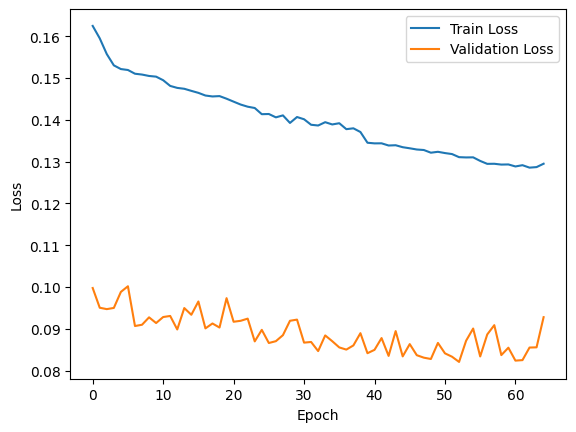

In [17]:
plt.plot(gat_train_losses, label='Train Loss')
plt.plot(gat_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

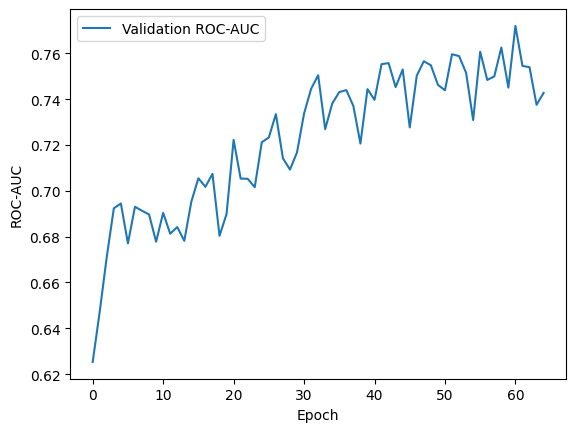

In [18]:
plt.plot(gat_val_rocaucs, label='Validation ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.legend()

### GAT with Hard Attention Pooling

In [19]:
SEED = 42
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [20]:
def topk(x, ratio, batch):
    """ Selects top-k nodes per graph in the batch. """
    num_nodes = x.size(0)
    batch_size = int(batch.max().item()) + 1
    out = torch.zeros(num_nodes, dtype=torch.bool, device=x.device)

    for i in range(batch_size):
        mask = (batch == i)
        scores = x[mask]
        k = max(1, int(ratio * mask.sum().item()))
        topk_indices = scores.argsort(descending=True)[:k]
        out[mask.nonzero(as_tuple=False)[topk_indices]] = True

    return out

In [21]:
class HardAttentionPool(nn.Module):
    def __init__(self, in_channels, ratio=0.5, hidden_channels=32):
        super().__init__()
        self.ratio = ratio
        self.score_layer = Sequential('x, edge_index', [
            (GCNConv(in_channels, hidden_channels), 'x, edge_index -> x'),
            nn.ReLU(inplace=True),
            (GCNConv(hidden_channels, hidden_channels), 'x, edge_index -> x'),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_channels, 1),
        ])

    def forward(self, x, edge_index, batch):
        scores = self.score_layer(x, edge_index).squeeze()
        perm = topk(scores, int(self.ratio * x.size(0)), batch)
        x = x[perm]
        batch = batch[perm]

        mask = perm[edge_index[0]] & perm[edge_index[1]]
        edge_index = edge_index[:, mask]

        return x, edge_index, batch

In [22]:
class GATWithHardAttnPooling(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=8, dropout=0.0):
        super().__init__()
        self.gat1 = GATv2Conv(in_dim, hidden_dim, heads=heads, concat=True, dropout=dropout)
        self.gat2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=dropout)
        self.attn_pool = HardAttentionPool(hidden_dim)
        self.lin = nn.Linear(hidden_dim, out_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch):
        x = x.float()
        x = F.elu(self.gat1(x, edge_index))
        x = self.dropout1(x)
        x = F.elu(self.gat2(x, edge_index))
        x = self.dropout2(x)
        x, edge_index, batch = self.attn_pool(x, edge_index, batch)
        x = global_mean_pool(x, batch)
        out = self.lin(x)
        return out


In [23]:
BATCH_SIZE = 64
NUM_EPOCHS = 65
LEARNING_RATE = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=BATCH_SIZE, shuffle=False)

In [25]:
gat_attn_pool_model = GATWithHardAttnPooling(
    in_dim=dataset.num_node_features,
    hidden_dim=128,
    out_dim=1,
    heads=4
).to(DEVICE)

In [26]:
optimizer = torch.optim.Adam(gat_attn_pool_model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, min_lr=1e-5)
evaluator = Evaluator(name="ogbg-molhiv")

In [27]:
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(DEVICE)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch).view(-1)
        loss = criterion(out, data.y.view(-1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []
    for data in loader:
        data = data.to(DEVICE)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.view(-1), data.y.view(-1).float())
        total_loss += loss.item() * data.num_graphs
        y_true.append(data.y)
        y_pred.append(out)

    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    avg_loss = total_loss / len(loader.dataset)
    rocauc = evaluator.eval({'y_true': y_true, 'y_pred': y_pred})['rocauc']
    return avg_loss, rocauc

In [28]:
gat_attn_train_losses = []
gat_attn_val_losses = []
gat_attn_val_rocaucs = []
for epoch in range(1, NUM_EPOCHS + 1):
    loss = train(gat_attn_pool_model, train_loader, optimizer)
    val_loss, val_rocauc = evaluate(gat_attn_pool_model, valid_loader)
    scheduler.step(val_rocauc)
    print(f"Epoch {epoch:03d} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f} | Val ROC-AUC: {val_rocauc:.4f}")
    gat_attn_train_losses.append(loss)
    gat_attn_val_losses.append(val_loss)
    gat_attn_val_rocaucs.append(val_rocauc)

Epoch 001 | Train Loss: 0.1631 | Val Loss: 0.1027 | Val ROC-AUC: 0.6200
Epoch 002 | Train Loss: 0.1582 | Val Loss: 0.1015 | Val ROC-AUC: 0.6548
Epoch 003 | Train Loss: 0.1563 | Val Loss: 0.0952 | Val ROC-AUC: 0.6779
Epoch 004 | Train Loss: 0.1542 | Val Loss: 0.0986 | Val ROC-AUC: 0.6879
Epoch 005 | Train Loss: 0.1531 | Val Loss: 0.0936 | Val ROC-AUC: 0.6900
Epoch 006 | Train Loss: 0.1519 | Val Loss: 0.0919 | Val ROC-AUC: 0.6739
Epoch 007 | Train Loss: 0.1514 | Val Loss: 0.1007 | Val ROC-AUC: 0.6766
Epoch 008 | Train Loss: 0.1507 | Val Loss: 0.0923 | Val ROC-AUC: 0.6906
Epoch 009 | Train Loss: 0.1502 | Val Loss: 0.0884 | Val ROC-AUC: 0.7110
Epoch 010 | Train Loss: 0.1496 | Val Loss: 0.0912 | Val ROC-AUC: 0.7077
Epoch 011 | Train Loss: 0.1490 | Val Loss: 0.0886 | Val ROC-AUC: 0.6987
Epoch 012 | Train Loss: 0.1491 | Val Loss: 0.0900 | Val ROC-AUC: 0.7219
Epoch 013 | Train Loss: 0.1480 | Val Loss: 0.0924 | Val ROC-AUC: 0.7277
Epoch 014 | Train Loss: 0.1470 | Val Loss: 0.0888 | Val ROC-AUC:

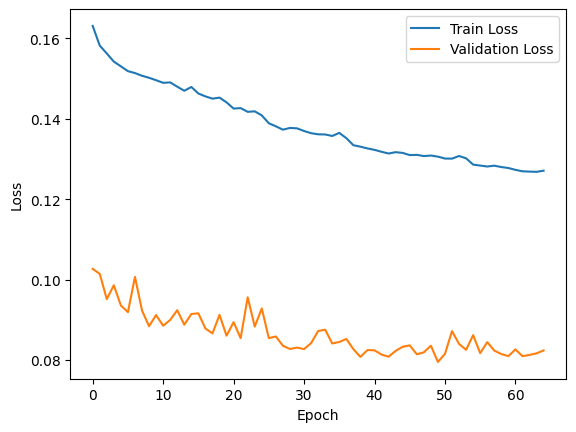

In [29]:
plt.plot(gat_attn_train_losses, label='Train Loss')
plt.plot(gat_attn_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

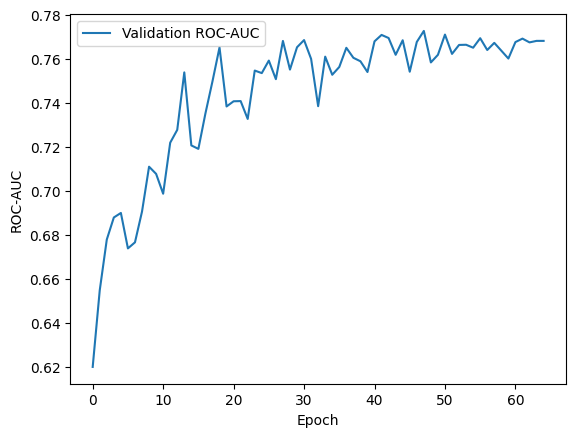

In [30]:
plt.plot(gat_attn_val_rocaucs, label='Validation ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

### GAT with Soft Attention Pooling

In [31]:
SEED = 42
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [32]:
BATCH_SIZE = 64
NUM_EPOCHS = 65
LEARNING_RATE = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
class SoftAttentionPool(nn.Module):
    def __init__(self, in_channels, hidden_channels=32):
        super().__init__()
        self.score_layer = Sequential('x, edge_index', [
            (GCNConv(in_channels, hidden_channels), 'x, edge_index -> x'),
            nn.ReLU(inplace=True),
            (GCNConv(hidden_channels, hidden_channels), 'x, edge_index -> x'),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_channels, 1),
        ])

    def forward(self, x, edge_index, batch):
        scores = self.score_layer(x, edge_index).squeeze()
        attn_weights = softmax(scores, batch)
        x_weighted = x * attn_weights.unsqueeze(-1)
        graph_emb = scatter_add(x_weighted, batch, dim=0)
        return graph_emb

In [34]:
class GATWithSoftAttnPooling(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=8, dropout=0.0):
        super().__init__()
        self.gat1 = GATv2Conv(in_dim, hidden_dim, heads=heads, concat=True, dropout=dropout)
        self.gat2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=dropout)
        self.attn_pool = SoftAttentionPool(hidden_dim)
        self.lin = nn.Linear(hidden_dim, out_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch):
        x = x.float()
        x = F.elu(self.gat1(x, edge_index))
        x = self.dropout1(x)
        x = F.elu(self.gat2(x, edge_index))
        x = self.dropout2(x)
        x = self.attn_pool(x, edge_index, batch)
        out = self.lin(x)
        return out


In [35]:
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=BATCH_SIZE, shuffle=False)

In [36]:
gat_soft_attn_model = GATWithSoftAttnPooling(
    in_dim=dataset.num_node_features,
    hidden_dim=128,
    out_dim=1,
    heads=4
).to(DEVICE)

In [37]:
optimizer = torch.optim.Adam(gat_soft_attn_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, min_lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()
evaluator = Evaluator(name="ogbg-molhiv")

In [38]:
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(DEVICE)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch).view(-1)
        loss = criterion(out, data.y.view(-1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []
    for data in loader:
        data = data.to(DEVICE)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.view(-1), data.y.view(-1).float())
        total_loss += loss.item() * data.num_graphs
        y_true.append(data.y)
        y_pred.append(out)

    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    avg_loss = total_loss / len(loader.dataset)
    rocauc = evaluator.eval({'y_true': y_true, 'y_pred': y_pred})['rocauc']
    return avg_loss, rocauc

In [39]:
gat_soft_attn_train_losses = []
gat_soft_attn_val_losses = []
gat_soft_attn_val_rocaucs = []
for epoch in range(1, NUM_EPOCHS + 1):
    loss = train(gat_soft_attn_model, train_loader, optimizer)
    val_loss, val_rocauc = evaluate(gat_soft_attn_model, valid_loader)
    scheduler.step(val_rocauc)
    print(f"Epoch {epoch:03d} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f} | Val ROC-AUC: {val_rocauc:.4f}")
    gat_soft_attn_train_losses.append(loss)
    gat_soft_attn_val_losses.append(val_loss)
    gat_soft_attn_val_rocaucs.append(val_rocauc)

Epoch 001 | Train Loss: 0.1615 | Val Loss: 0.1025 | Val ROC-AUC: 0.6200
Epoch 002 | Train Loss: 0.1513 | Val Loss: 0.0994 | Val ROC-AUC: 0.6224
Epoch 003 | Train Loss: 0.1503 | Val Loss: 0.0958 | Val ROC-AUC: 0.6315
Epoch 004 | Train Loss: 0.1500 | Val Loss: 0.1031 | Val ROC-AUC: 0.6259
Epoch 005 | Train Loss: 0.1501 | Val Loss: 0.0922 | Val ROC-AUC: 0.6286
Epoch 006 | Train Loss: 0.1490 | Val Loss: 0.0941 | Val ROC-AUC: 0.6410
Epoch 007 | Train Loss: 0.1491 | Val Loss: 0.1077 | Val ROC-AUC: 0.6254
Epoch 008 | Train Loss: 0.1485 | Val Loss: 0.0989 | Val ROC-AUC: 0.6229
Epoch 009 | Train Loss: 0.1465 | Val Loss: 0.0941 | Val ROC-AUC: 0.6399
Epoch 010 | Train Loss: 0.1444 | Val Loss: 0.0937 | Val ROC-AUC: 0.6462
Epoch 011 | Train Loss: 0.1438 | Val Loss: 0.0914 | Val ROC-AUC: 0.6370
Epoch 012 | Train Loss: 0.1442 | Val Loss: 0.0973 | Val ROC-AUC: 0.6295
Epoch 013 | Train Loss: 0.1440 | Val Loss: 0.0919 | Val ROC-AUC: 0.6394
Epoch 014 | Train Loss: 0.1445 | Val Loss: 0.0934 | Val ROC-AUC:

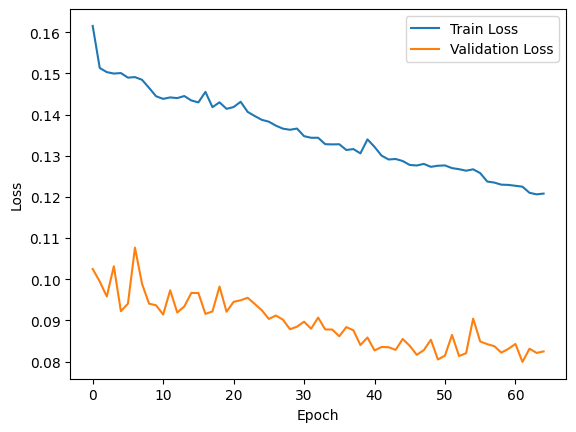

In [40]:
plt.plot(gat_soft_attn_train_losses, label='Train Loss')
plt.plot(gat_soft_attn_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

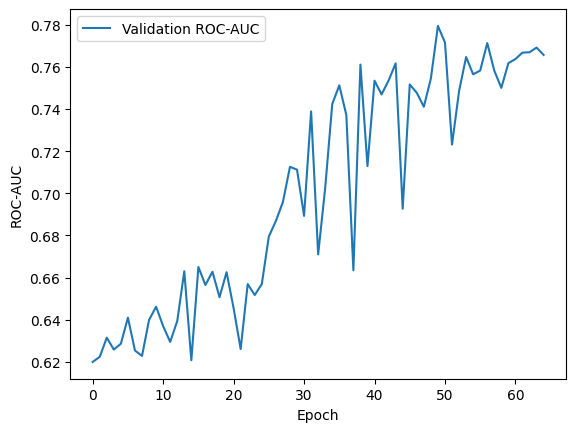

In [41]:
plt.plot(gat_soft_attn_val_rocaucs, label='Validation ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.legend()

### Wavelet Attention

In [42]:
SEED = 42
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [43]:
BATCH_SIZE = 64
NUM_EPOCHS = 65
LEARNING_RATE = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
class ScaleAttention(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.att_proj = nn.Linear(feature_dim, 1, bias=False)

    def forward(self, x_scales):
        x_stack = torch.stack(x_scales, dim=1)
        attn_logits = self.att_proj(x_stack)
        attn_weights = torch.softmax(attn_logits, dim=1)
        out = (attn_weights * x_stack).sum(dim=1)
        return out

In [45]:
class WaveletAttentionGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim, num_scales):
        super().__init__()
        self.num_scales = num_scales
        self.chebconv_layers = nn.ModuleList([
            ChebConv(in_channels, hidden_channels, K=k)
            for k in range(1, num_scales+1)
        ])
        self.attn = ScaleAttention(feature_dim=hidden_channels)
        self.mlp_out = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels),
        )
        self.edge_proj = nn.Sequential(
            nn.Linear(edge_dim, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, edge_index, edge_attr, batch):
        x = x.float()
        edge_attr = edge_attr.float()
        edge_weight = self.edge_proj(edge_attr).squeeze(-1)
        x_wavelets = [
            chebconv(x, edge_index, edge_weight=edge_weight, batch=batch)
            for chebconv in self.chebconv_layers
        ]
        x = self.attn(x_wavelets)
        x = global_mean_pool(x, batch)
        x = self.mlp_out(x)
        return x


In [46]:
wavelet_model = WaveletAttentionGNN(
    in_channels=dataset.num_node_features,
    hidden_channels=128,
    out_channels=1,
    edge_dim=dataset.num_edge_features,
    num_scales=12,
).to(DEVICE)

In [47]:
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=BATCH_SIZE, shuffle=False)

In [48]:
optimizer = torch.optim.Adam(wavelet_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, min_lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()
evaluator = Evaluator(name="ogbg-molhiv")

In [49]:
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(DEVICE)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch).view(-1)
        loss = criterion(out, data.y.view(-1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []
    for data in loader:
        data = data.to(DEVICE)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out.view(-1), data.y.view(-1).float())
        total_loss += loss.item() * data.num_graphs
        y_true.append(data.y)
        y_pred.append(out)

    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    avg_loss = total_loss / len(loader.dataset)
    rocauc = evaluator.eval({'y_true': y_true, 'y_pred': y_pred})['rocauc']
    return avg_loss, rocauc

In [50]:
wavelet_train_losses = []
wavelet_val_losses = []
wavelet_val_rocaucs = []
for epoch in range(1, NUM_EPOCHS + 1):
    loss = train(wavelet_model, train_loader, optimizer)
    val_loss, val_rocauc = evaluate(wavelet_model, valid_loader)
    scheduler.step(val_rocauc)
    print(f"Epoch {epoch:03d} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f} | Val ROC-AUC: {val_rocauc:.4f}")
    wavelet_train_losses.append(loss)
    wavelet_val_losses.append(val_loss)
    wavelet_val_rocaucs.append(val_rocauc)

Epoch 001 | Train Loss: 0.1648 | Val Loss: 0.0949 | Val ROC-AUC: 0.6561
Epoch 002 | Train Loss: 0.1607 | Val Loss: 0.0956 | Val ROC-AUC: 0.6587
Epoch 003 | Train Loss: 0.1596 | Val Loss: 0.1056 | Val ROC-AUC: 0.6520
Epoch 004 | Train Loss: 0.1579 | Val Loss: 0.0929 | Val ROC-AUC: 0.6620
Epoch 005 | Train Loss: 0.1568 | Val Loss: 0.0932 | Val ROC-AUC: 0.6985
Epoch 006 | Train Loss: 0.1533 | Val Loss: 0.0968 | Val ROC-AUC: 0.6877
Epoch 007 | Train Loss: 0.1510 | Val Loss: 0.0976 | Val ROC-AUC: 0.6994
Epoch 008 | Train Loss: 0.1501 | Val Loss: 0.0949 | Val ROC-AUC: 0.7243
Epoch 009 | Train Loss: 0.1491 | Val Loss: 0.0892 | Val ROC-AUC: 0.7230
Epoch 010 | Train Loss: 0.1488 | Val Loss: 0.0981 | Val ROC-AUC: 0.7313
Epoch 011 | Train Loss: 0.1472 | Val Loss: 0.0894 | Val ROC-AUC: 0.7212
Epoch 012 | Train Loss: 0.1470 | Val Loss: 0.0942 | Val ROC-AUC: 0.7393
Epoch 013 | Train Loss: 0.1457 | Val Loss: 0.0873 | Val ROC-AUC: 0.7182
Epoch 014 | Train Loss: 0.1461 | Val Loss: 0.0873 | Val ROC-AUC:

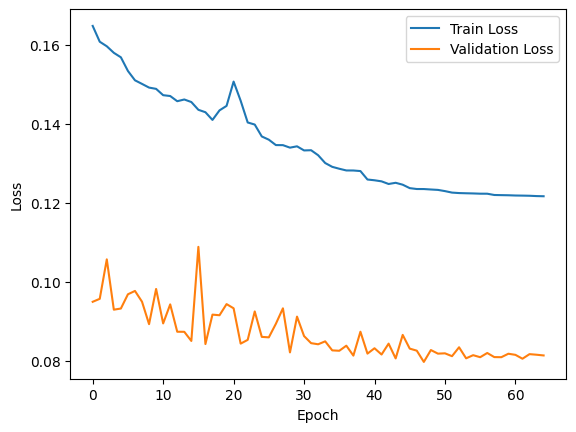

In [51]:
plt.plot(wavelet_train_losses, label='Train Loss')
plt.plot(wavelet_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

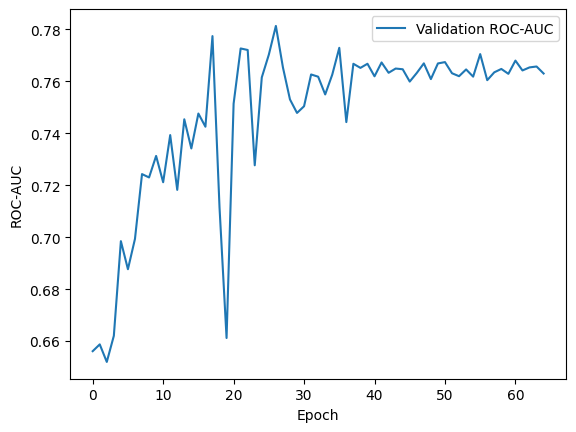

In [52]:
plt.plot(wavelet_val_rocaucs, label='Validation ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.legend()

### Comparison

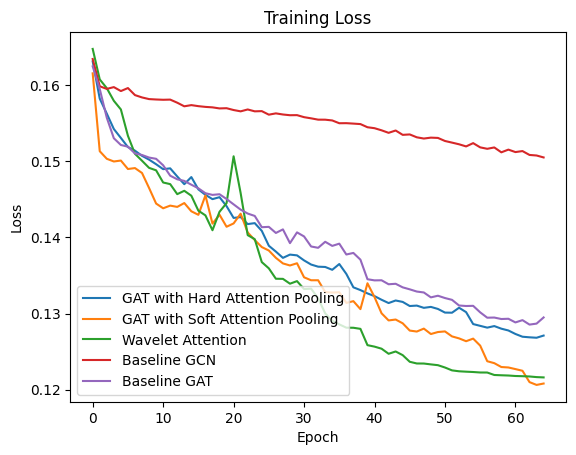

In [93]:
plt.plot(gat_attn_train_losses, label='GAT with Hard Attention Pooling')
plt.plot(gat_soft_attn_train_losses, label='GAT with Soft Attention Pooling')
plt.plot(wavelet_train_losses, label='Wavelet Attention')
plt.plot(gcn_train_losses, label='Baseline GCN')
plt.plot(gat_train_losses, label='Baseline GAT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

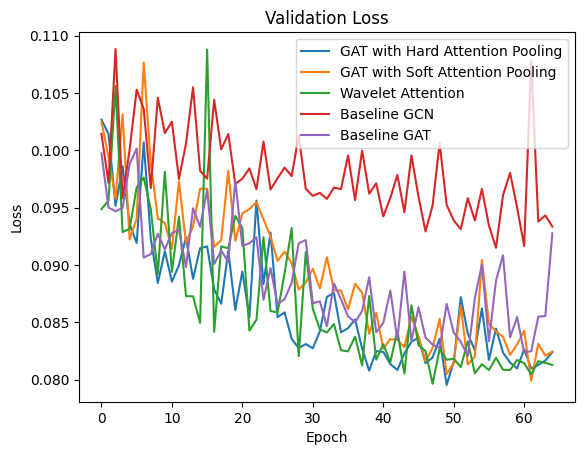

In [94]:
plt.plot(gat_attn_val_losses, label='GAT with Hard Attention Pooling')
plt.plot(gat_soft_attn_val_losses, label='GAT with Soft Attention Pooling')
plt.plot(wavelet_val_losses, label='Wavelet Attention')
plt.plot(gcn_val_losses, label='Baseline GCN')
plt.plot(gat_val_losses, label='Baseline GAT')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss')
plt.show()

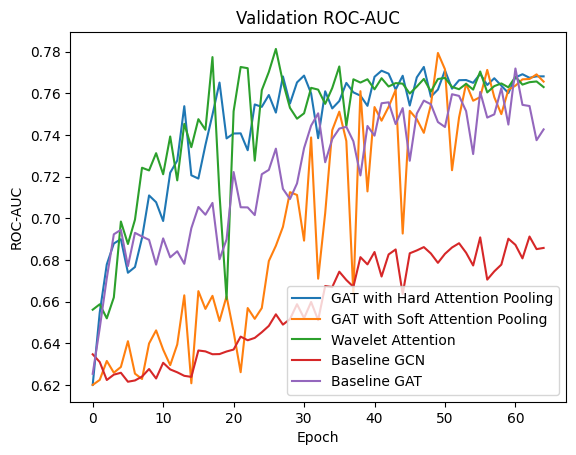

In [95]:
plt.plot(gat_attn_val_rocaucs, label='GAT with Hard Attention Pooling')
plt.plot(gat_soft_attn_val_rocaucs, label='GAT with Soft Attention Pooling')
plt.plot(wavelet_val_rocaucs, label='Wavelet Attention')
plt.plot(gcn_val_rocaucs, label='Baseline GCN')
plt.plot(gat_val_rocaucs, label='Baseline GAT')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.legend()
plt.title('Validation ROC-AUC')
plt.show()

### Analysis

In [56]:
@torch.no_grad()
def gat_metrics(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for data in loader:
        data = data.to(DEVICE)
        out = model(data.x, data.edge_index, data.batch)
        y_true.append(data.y)
        y_pred.append(F.sigmoid(out))

    y_true = torch.cat(y_true, dim=0).cpu().numpy()
    y_pred = torch.cat(y_pred, dim=0).cpu().numpy()
    y_pred_labels = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_labels)
    roc_auc = roc_auc_score(y_true, y_pred)
    return accuracy, roc_auc

@torch.no_grad()
def wavelet_metrics(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for data in loader:
        data = data.to(DEVICE)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        y_true.append(data.y)
        y_pred.append(F.sigmoid(out))
    y_true = torch.cat(y_true, dim=0).cpu().numpy()
    y_pred = torch.cat(y_pred, dim=0).cpu().numpy()
    y_pred_labels = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_labels)
    roc_auc = roc_auc_score(y_true, y_pred)
    return accuracy, roc_auc

### Training Metrics

In [96]:
for model in [gcn_model, gat_model, gat_attn_pool_model, gat_soft_attn_model]:
    print(model.__class__.__name__)
    accuracy, roc_auc = gat_metrics(model, train_loader)
    print(f"Accuracy: {accuracy:.4f} | ROC-AUC: {roc_auc:.4f}")
    print()
print(wavelet_model.__class__.__name__)
accuracy, roc_auc = wavelet_metrics(wavelet_model, train_loader)
print(f"Accuracy: {accuracy:.4f} | ROC-AUC: {roc_auc:.4f}")
print()

GCN
Accuracy: 0.9625 | ROC-AUC: 0.6861

GAT
Accuracy: 0.9639 | ROC-AUC: 0.7954

GATWithHardAttnPooling
Accuracy: 0.9636 | ROC-AUC: 0.8021

GATWithSoftAttnPooling
Accuracy: 0.9668 | ROC-AUC: 0.8098

WaveletAttentionGNN
Accuracy: 0.9668 | ROC-AUC: 0.8139



### Validation Metrics

In [97]:
for model in [gcn_model, gat_model, gat_attn_pool_model, gat_soft_attn_model]:
    print(model.__class__.__name__)
    accuracy, roc_auc = gat_metrics(model, valid_loader)
    print(f"Accuracy: {accuracy:.4f} | ROC-AUC: {roc_auc:.4f}")
    print()
print(wavelet_model.__class__.__name__)
accuracy, roc_auc = wavelet_metrics(wavelet_model, valid_loader)
print(f"Accuracy: {accuracy:.4f} | ROC-AUC: {roc_auc:.4f}")
print()

GCN
Accuracy: 0.9803 | ROC-AUC: 0.6858

GAT
Accuracy: 0.9815 | ROC-AUC: 0.7427

GATWithHardAttnPooling
Accuracy: 0.9803 | ROC-AUC: 0.7682

GATWithSoftAttnPooling
Accuracy: 0.9808 | ROC-AUC: 0.7657

WaveletAttentionGNN
Accuracy: 0.9815 | ROC-AUC: 0.7630

